In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from torch_geometric.loader import DataLoader
from CustomDataset import CustomDataset

%config InlineBackend.figure_format = 'png2x'
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5    # Axis line width
plt.rcParams['lines.linewidth'] = 1    # Line width
plt.rcParams['xtick.major.width'] = 0.5  # Set x major tick width to 2 points
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['lines.markersize'] = 4
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [51]:
# Number of time steps
nt = 12

# Number of testing data
test_size = 200

# Number of branches
num_branches = 186

# Power flow limit
file_path = f'../../data/IEEE_Case118/branch_params/PF_max_category1.csv'
PF_max_category1 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()
file_path = f'../../data/IEEE_Case118/branch_params/PF_max_category2.csv'
PF_max_category2 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()
file_path = f'../../data/IEEE_Case118/branch_params/PF_max_category3.csv'
PF_max_category3 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()

# Set line flow threshold
epsilon = 0.85

PF_max1 = 200
PF_max2 = 300
PF_max3 = 500

PF_threshold = np.zeros((num_branches, nt))
PF_threshold[PF_max_category1, :] = epsilon * PF_max1
PF_threshold[PF_max_category2, :] = epsilon * PF_max2
PF_threshold[PF_max_category3, :] = epsilon * PF_max3

In [52]:
# Matrix to store results
prob_true = []
prob_pred = []

# Read PF file
for i in range(test_size):
    # Ground truth
    file_path = f'../../res/IEEE_Case118/model_evaluation/PF/true_corr/true_corr_{i+1}.csv'
    temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    res = (np.abs(temp) >= PF_threshold)
    prob_true.append(res.copy())

    # Prediction
    file_path = f'../../res/IEEE_Case118/model_evaluation/PF/pred_corr/pred_corr_{i+1}.csv'
    temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    res = (np.abs(temp) >= PF_threshold)
    prob_pred.append(res.copy())

# Convert to numpy array
prob_true = np.array(prob_true)
prob_pred = np.array(prob_pred)

In [53]:
# Probability of heavying loading
prob_true = prob_true.mean(axis=0)
prob_pred = prob_pred.mean(axis=0)

# Get sorted branch index according to mean probability of ground truth
sorted_idx = np.argsort(prob_true.T.mean(axis=0))

# Select six important branches
num_top_branches = 9
top_branch_idx = sorted_idx[-num_top_branches:]

# Sort top branch index
# top_branch_idx = np.sort(top_branch_idx)

top_branch_idx

array([128, 127,   8,   6,  37, 150, 175, 174, 133])

## All branches

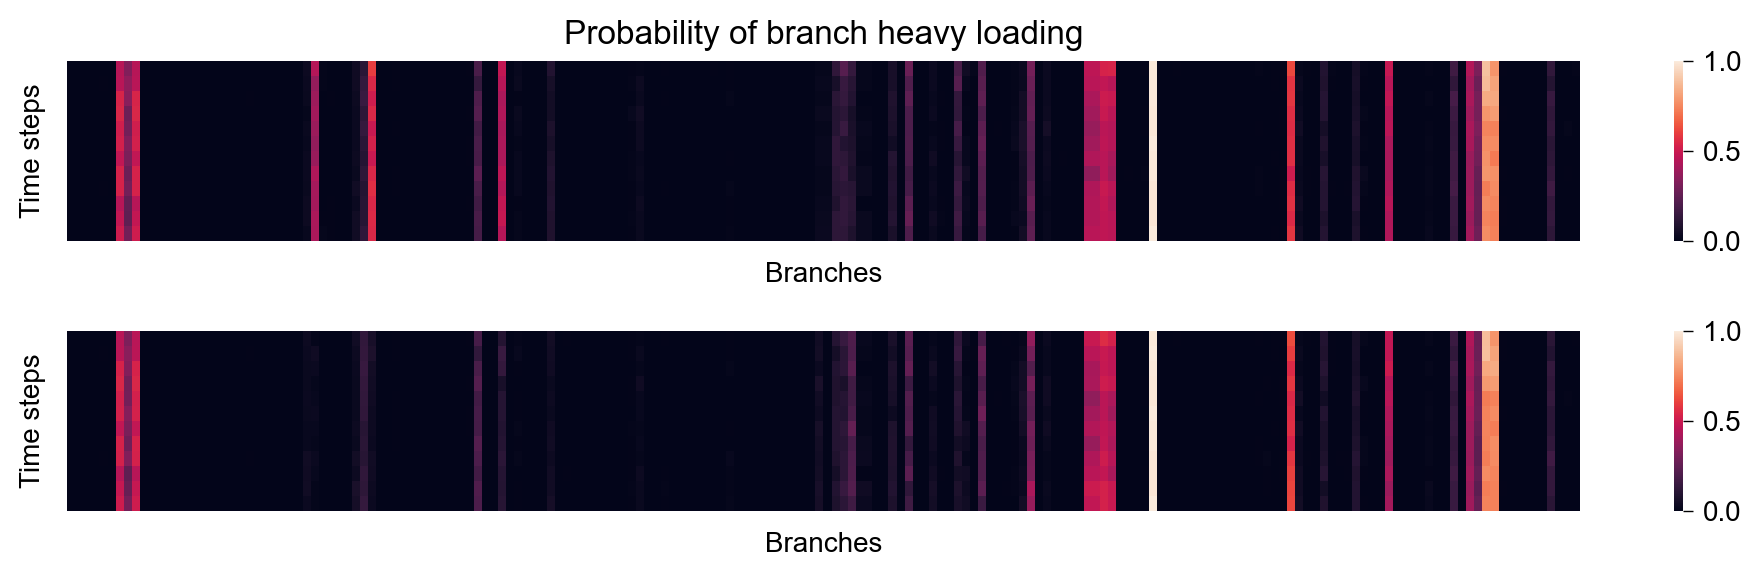

In [54]:
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(211)
sns.heatmap(prob_true.T, ax=ax1, vmin=0, vmax=1, xticklabels=[], yticklabels=[])
ax1.set_title('Probability of branch heavy loading')
ax1.set_xlabel('Branches')
ax1.set_ylabel('Time steps')

ax2 = fig.add_subplot(212)
sns.heatmap(prob_pred.T, ax=ax2, vmin=0, vmax=1, xticklabels=[], yticklabels=[])
ax2.set_xlabel('Branches')
ax2.set_ylabel('Time steps')

plt.tight_layout()
plt.show()
plt.close('all')

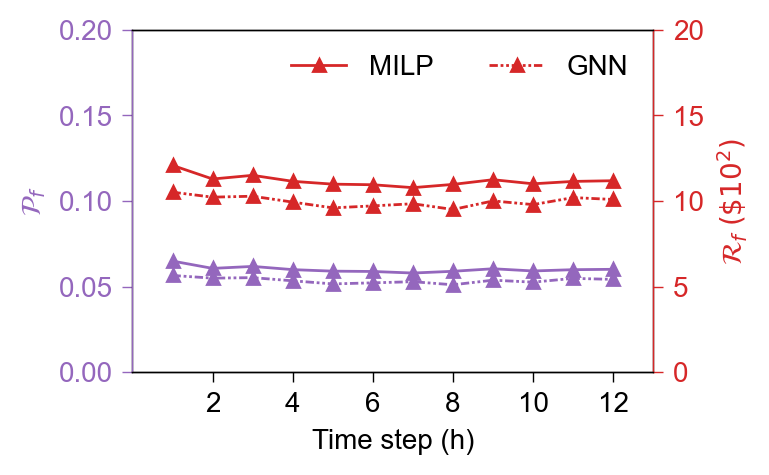

In [108]:
# Plot probability for individual branch
x = np.arange(1, 13)

# Reliability
fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(111)
ax.plot(x, prob_true.mean(axis=0), color=colors[4], marker='^', label='MILP')
ax.plot(x, prob_pred.mean(axis=0), linestyle=(0, (3, 1, 1, 1, 1, 1)), color=colors[4], marker='^', label='GNN')
ax.set_xlabel('Time step (h)')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_ylim((0, 0.2))
ax.set_ylabel('$\mathcal{P}_f$')
ax.tick_params(axis='y', colors=colors[4])
ax.yaxis.label.set_color(colors[4])

# Risk = prob * num_branches * $100, $100 will be manifested in y label
cost = prob_true.shape[0]

ax = ax.twinx()
ax.plot(x, prob_true.mean(axis=0)*cost, color=colors[3], marker='^', label='MILP')
ax.plot(x, prob_pred.mean(axis=0)*cost, linestyle=(0, (3, 1, 1, 1, 1, 1)), color=colors[3], marker='^', label='GNN')
ax.set_ylim((0, 20))
ax.set_ylabel('$\mathcal{R}_f \; (\$ 10^2)$')
ax.tick_params(axis='y', colors=colors[3])
ax.yaxis.label.set_color(colors[3])
ax.spines['left'].set_color(colors[4])
ax.spines['right'].set_color(colors[3])
ax.legend(loc='upper right', ncols=2, frameon=False)

plt.tight_layout()
plt.show()
plt.close('all')


## Significant branches

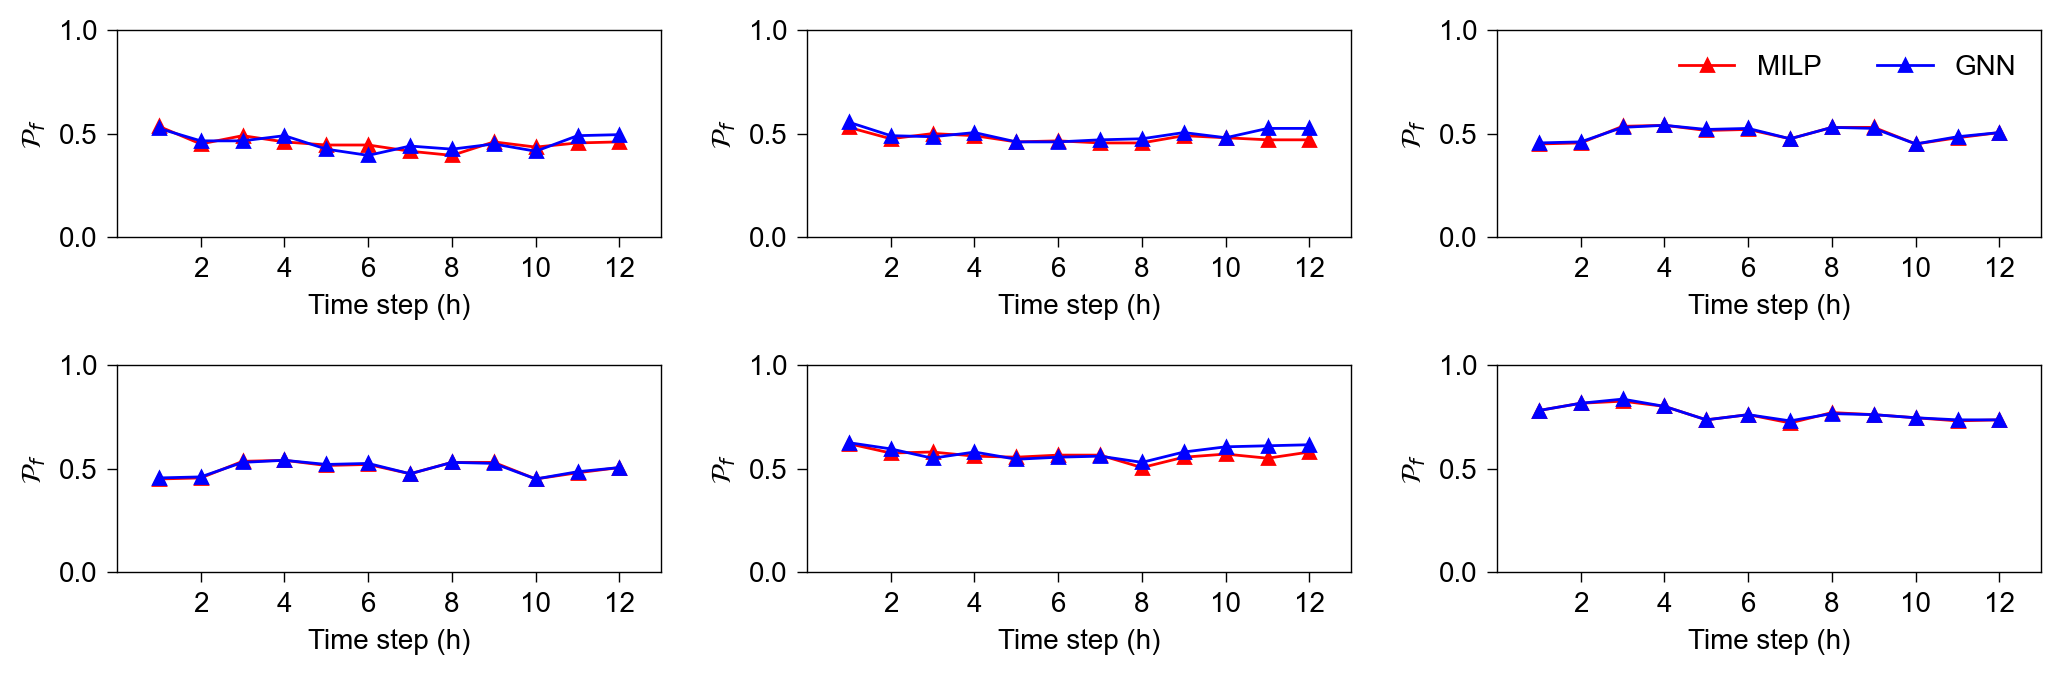

In [56]:
# Plot probability for individual branch
fig = plt.figure(figsize=(10.5, 3.5))

x = np.arange(1, 13)

ax = fig.add_subplot(231)
ax.plot(x, prob_true[top_branch_idx[0]], color='red', marker='^', label='MILP')
ax.plot(x, prob_pred[top_branch_idx[0]], color='blue', marker='^', label='GNN')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time step (h)')
ax.set_ylim((0, 1))
ax.set_ylabel('$\mathcal{P}_f$')
# ax.legend(loc='upper right', ncols=2, frameon=False)

ax = fig.add_subplot(232)
ax.plot(x, prob_true[top_branch_idx[1]], color='red', marker='^', label='MILP')
ax.plot(x, prob_pred[top_branch_idx[1]], color='blue', marker='^', label='GNN')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time step (h)')
ax.set_ylim((0, 1))
ax.set_ylabel('$\mathcal{P}_f$')

ax = fig.add_subplot(233)
ax.plot(x, prob_true[top_branch_idx[2]], color='red', marker='^', label='MILP')
ax.plot(x, prob_pred[top_branch_idx[2]], color='blue', marker='^', label='GNN')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time step (h)')
ax.set_ylim((0, 1))
ax.set_ylabel('$\mathcal{P}_f$')
ax.legend(loc='upper right', ncols=2, frameon=False)

ax = fig.add_subplot(234)
ax.plot(x, prob_true[top_branch_idx[3]], color='red', marker='^', label='MILP')
ax.plot(x, prob_pred[top_branch_idx[3]], color='blue', marker='^', label='GNN')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time step (h)')
ax.set_ylim((0, 1))
ax.set_ylabel('$\mathcal{P}_f$')

ax = fig.add_subplot(235)
ax.plot(x, prob_true[top_branch_idx[5]], color='red', marker='^', label='MILP')
ax.plot(x, prob_pred[top_branch_idx[5]], color='blue', marker='^', label='GNN')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time step (h)')
ax.set_ylim((0, 1))
ax.set_ylabel('$\mathcal{P}_f$')


ax = fig.add_subplot(236)
ax.plot(x, prob_true[top_branch_idx[6]], color='red', marker='^', label='MILP')
ax.plot(x, prob_pred[top_branch_idx[6]], color='blue', marker='^', label='GNN')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_xlabel('Time step (h)')
ax.set_ylim((0, 1))
ax.set_ylabel('$\mathcal{P}_f$')


plt.tight_layout()
plt.show()
plt.close('all')